# Potential Talents

- Author: Yumo Bai
- Email: baiym104@gmail.com
- Date: Mar 16, 2023

## Loading Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Wrangling

In [4]:
df = pd.read_csv('./data/potential-talents - Aspiring human resources - seeking human resources.csv')
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


### Wrangling `location`

We have the current job title of the candidates as well as their location and how many connections they have. The location could have been a criteria for initial ranking if there was information given about the location of the company and if there exists any geological preference when selecting a candidate.

We could also argue that the location distribution of candidates applying for this job represents the size of the labor force at that location and thereby imply a higher likelihood of a candidate having more human resource comparing to candidates from a location with less number of candidates.

We can get a sense of the candidate distribution by processing the location data and plotting.

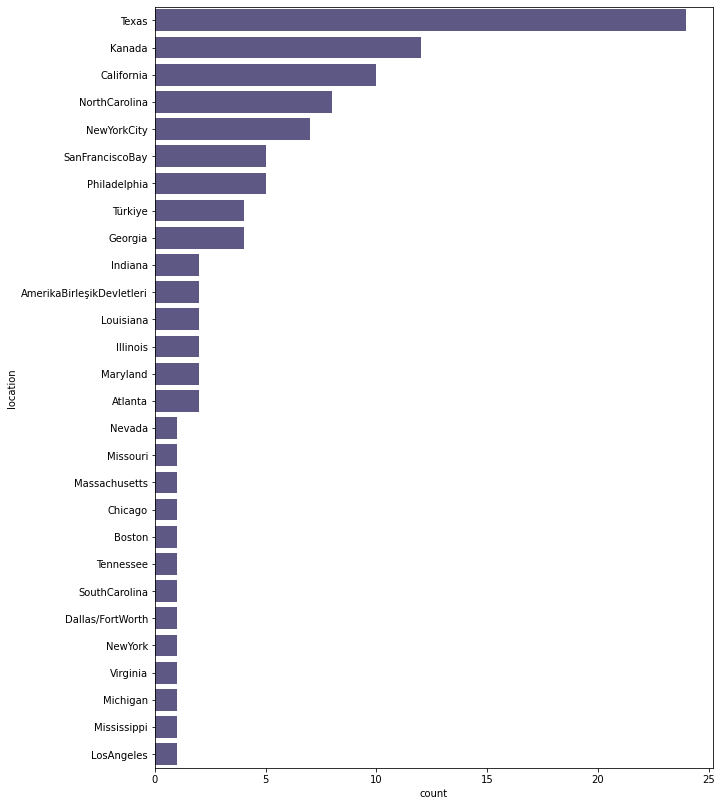

In [6]:
# We will take the last sector of the location data as the location of the candidate
df['location'] = df['location'].apply(lambda x: x.split(',')[-1])

# As there are different naming to the same location, i.e Greater Texas Area vs Texas, 
# we need to strip the location to the same representation
remove_texts = ['Greater', 'Area', ' ']
for text in remove_texts:
    df['location'] = df['location'].apply(lambda x: x.replace(text, ''))

# plot the distribution of the candidates
plt.figure(figsize=(10, 0.5*len(df['location'].value_counts())))
sns.countplot(y='location', data=df, order = df['location'].value_counts().index, color="#58508d")
plt.show()

The locations with the most candidates are Texas, California, North Carolina and NYC. There are also 12 Canadian candidates. Now that we have processed the location data and get the distribution of the candidates, we can see if there is evidence supporting our hypothesis by verifying if candidates from the top locations have more connections than candidates from the other locations.

In [7]:
# First we need to convert connections to numerical
df['connection'] = df['connection'].apply(lambda x: int(x.replace('+', '')))

In [8]:
location_connection_df = df.groupby('location')['connection']\
        .describe()[['count', 'mean']]\
        .sort_values(by='count',ascending=False)\
        .reset_index()
location_connection_df

,location,count,mean
0,Texas,24.0,305.708333
1,Kanada,12.0,243.916667
2,California,10.0,91.700000
3,NorthCarolina,8.0,158.000000
4,NewYorkCity,7.0,79.142857
5,SanFranciscoBay,5.0,500.000000
6,Philadelphia,5.0,500.000000
7,Georgia,4.0,500.000000
8,Türkiye,4.0,500.000000
9,Illinois,2.0,390.000000


There is no evidence supporting the assumption that locations with higher amount of candidates would have higher average connections per candidate. Therefore we will skip it for now and focus on `job_title` and `connection` which are probably more reliable as the criterion for the initial ranking.

We will still consider using `location` when re-ranking the candidates when anyone is starred.

### Wrangling `connection`

As we have converted the connection data into numerical values, we can visualize the connection numbers with a histogram.

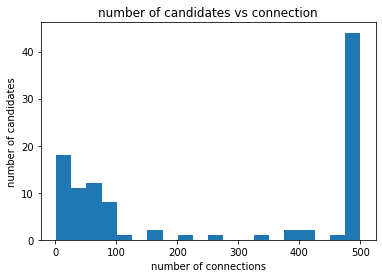

In [9]:
plt.hist(df['connection'], bins=20)
plt.xlabel('number of connections')
plt.ylabel('number of candidates')
plt.title('number of candidates vs connection')
plt.show()

Most of the candidates have either lower than 100 connections or 500+ of connections. Considering the job is regarding human resourcing, it is safe to assume that having more connections should considered an asset.

We can develop a metric called `connection_factor` which is the weight factor of the number of connections with 0 equal to 0 and 500 equal to 1.

In [10]:
df['connection_factor'] = df['connection']/500

We will get the semantics of the `job_title` with embeddings. We will achieve this using BERT Tokenizer.

In [16]:
!pip install pytorch-pretrained-bert pytorch-nlp
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.2 MB/s eta 0:00:00


In [17]:
import torch
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig

In [19]:
# Create sentence and label lists
sentences = df['job_title'].values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 420165.44B/s]


Tokenize the first sentence:
['[CLS]', '2019', 'c', '.', 't', '.', 'bauer', 'college', 'of', 'business', 'graduate', '(', 'magna', 'cum', 'laude', ')', 'and', 'aspiring', 'human', 'resources', 'professional', '[SEP]']


In [20]:
MAX_LEN = 128
KEYWORDS = [“Aspiring human resources”, “seeking human resources”]

In [21]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [22]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [23]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [25]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs = train_test_split(input_ids, 
                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [26]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [28]:
df['job_title'][:5]

0    2019 C.T. Bauer College of Business Graduate (...
1    Native English Teacher at EPIK (English Progra...
2                Aspiring Human Resources Professional
3               People Development Coordinator at Ryan
4      Advisory Board Member at Celal Bayar University
Name: job_title, dtype: object

In [27]:
train_inputs[:5]

tensor([[  101,  2472,  1997,  2529,  4219,  2167,  2637,  1010,  2177,  2063,
          3841, 12870,  4887,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

Now that we have tokenized the input sentences into numerical representation, we can now move on to 